## Assigment: Neural network basics

Soft deadline: 16.09.18 at 23.59

Hard deadline: 18.09.18 at 23.59

For this task I intentionally provide no boilerplate code, because very puprpose of this task is getting you comforatable with basic code template for desiging NNs in pytorch. I higly recommend you to revisit all the last seminar materials.

#### Task

* Implement simple **convolutional** neural architecture for classification. Make sure it is small enought to run on your home machine.
* Provide dataset visulization.
* Provide train/test split and validation

#### Requirements

* Architecture should derive from `torch.nn.Module`
* Use `torch.utils.data.Dataset` and `torch.utils.data.DataLoader`. But if you manage co simplify this step using dataset `torchivision`, I will only encourage you.
* Implement at least one data transformer, but make sure it is useful for classification task.
* Use FashionMNIST dataset https://github.com/zalandoresearch/fashion-mnist
* Make sure you can fix random seed for all components of your code to make experiments reproducible
* Since you architecure should be fully-convolutional, make sure it does not depend on input size.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader



In [9]:
torch.manual_seed(63997)

device = torch.device('cpu')

image_sz = 28

In [10]:
dataset_dir = "fasion_mnist"
transform = transforms.Compose([
    transforms.RandomCrop(image_sz, padding=3),
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(dataset_dir, train=True, download=True, transform=transform)

test_dataset = datasets.FashionMNIST(dataset_dir, train=False, download=True, transform=transforms.ToTensor())

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

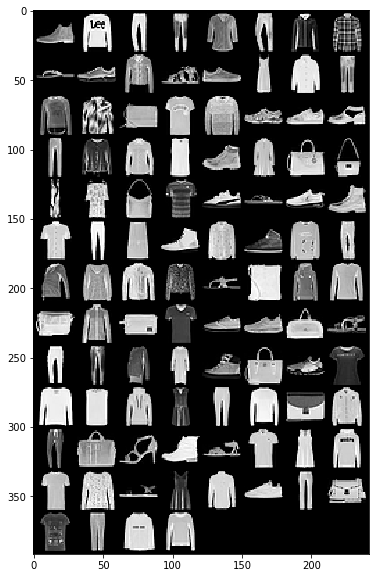

In [11]:
def visualize_images(images):
    def show(img):
        npimg = img.numpy()
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    grid = torchvision.utils.make_grid(images, )
    show(grid)

images, _ = next(DataLoader(dataset=test_dataset, batch_size=100).__iter__())

visualize_images(images)

In [12]:
def visualize_loss(train_loss, test_loss):
    plt.plot(np.arange(1, len(train_loss) + 1), train_loss, label='test loss')
    plt.plot(np.arange(1, len(test_loss) + 1), test_loss, label='train loss')
    plt.legend()
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

def train(model, train_dataset, test_dataset, *, learning_rate=1e-3, epochs=20, batch_size=100):
    train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    def average_loss(dataloader):
        with torch.no_grad():
            losses = []
            for batch_id, (image, label) in enumerate(dataloader):
                if (batch_id > 200):
                    break
                label, image = label.to(device), image.to(device)
                output = model(image)
                loss = criterion(output, label)
                losses.append(loss.item())
        return np.average(losses)
        
    train_losses = []
    test_losses = []
    for epoch in range(1, epochs + 1):
        print("epoch {}/{}".format(epoch, epochs))
        for batch_id, (image, label) in enumerate(train_dataloader):
            optimizer.zero_grad()
            
            label, image = label.to(device), image.to(device)
            output = model(image)
            loss = criterion(output, label)
            
            loss.backward()
            optimizer.step()
        train_losses.append(average_loss(train_dataloader))
        test_losses.append(average_loss(test_dataloader))
    visualize_loss(train_losses, test_losses)

epoch 1/25


epoch 2/25


epoch 3/25


epoch 4/25


epoch 5/25


epoch 6/25


epoch 7/25


epoch 8/25


epoch 9/25


epoch 10/25


epoch 11/25


epoch 12/25


epoch 13/25


epoch 14/25


epoch 15/25


epoch 16/25


epoch 17/25


epoch 18/25


epoch 19/25


epoch 20/25


epoch 21/25


epoch 22/25


epoch 23/25


epoch 24/25


epoch 25/25


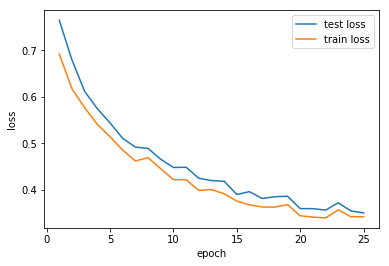

In [17]:
class Net(nn.Module):
    def __init__(self, size_n=28, size_m=28, classes=10):
        super(Net, self).__init__()
        kernel = 5
        conv_channels_1 = 4
        conv_channels_2 = 10
        hidden_layer_size = 30
        padding = kernel // 2
        max_pool_size = 2
        
        self.size_n = size_n
        self.size_m = size_m
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, conv_channels_1, kernel_size=kernel, padding=padding),
            nn.ReLU(),
            nn.MaxPool2d(max_pool_size)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(conv_channels_1, conv_channels_2, kernel_size=kernel, padding=padding),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(conv_channels_2, conv_channels_2, kernel_size=kernel, padding=padding),
            nn.ReLU()
        )
        size_n = size_n // max_pool_size
        size_m = size_m // max_pool_size
        
        self.lin1 = nn.Linear(size_n * size_m * conv_channels_2, hidden_layer_size)
        self.lin2 = nn.Linear(hidden_layer_size, classes)
        
            
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(-1, x[0].numel())
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return x


model = Net().to(device)
train(model, train_dataset, test_dataset, epochs=25, learning_rate=5e-4)

In [18]:
def test(model, dataset):
    dataloader = DataLoader(dataset=dataset, batch_size=100)
    
    correct = 0
    total = 0
    predicted_count = np.zeros(len(classes))
    class_count = np.zeros(len(classes))
    correct_count = np.zeros(len(classes))
    for image, label in dataloader:
        image, label = image.to(device), label.to(device)
        outputs = model(image)
        predicted = torch.argmax(outputs,dim=1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
        for c in predicted:
            predicted_count[c] += 1
        for c in label:
            class_count[c] += 1
        for c in label[predicted == label]:
            correct_count[c] += 1
    print("accuracy: {}%".format(100 * correct / total))
    
    recall = correct_count / class_count
    precision = correct_count / predicted_count 
    for i, clazz in enumerate(classes):
        print("class {}, precision {:3.2f}%, recall {:3.2f}%".format(clazz, 100 * precision[i], 100 * recall[i]))
        
test(model, test_dataset)

print()
print("Train: ")
test(model, train_dataset)

accuracy: 87.41%
class T-shirt/top, precision 88.31%, recall 71.80%
class Trouser, precision 97.23%, recall 98.30%
class Pullover, precision 80.71%, recall 77.40%
class Dress, precision 87.76%, recall 88.90%
class Coat, precision 74.01%, recall 83.70%
class Sandal, precision 98.96%, recall 94.90%
class Shirt, precision 64.46%, recall 68.20%
class Sneaker, precision 93.72%, recall 95.50%
class Bag, precision 96.95%, recall 98.50%
class Ankle boot, precision 94.91%, recall 96.90%

Train: 


accuracy: 86.785%
class T-shirt/top, precision 88.33%, recall 72.25%
class Trouser, precision 96.83%, recall 98.38%
class Pullover, precision 80.87%, recall 76.08%
class Dress, precision 85.78%, recall 90.50%
class Coat, precision 73.89%, recall 81.45%
class Sandal, precision 98.44%, recall 93.62%
class Shirt, precision 63.40%, recall 67.10%
class Sneaker, precision 93.97%, recall 93.78%
class Bag, precision 95.39%, recall 97.57%
class Ankle boot, precision 93.59%, recall 97.12%
